# Run a quick layer fidelity experiment on a qubit chain  (default is the most recent 100Q chain from qiskit)

Run layer fidelity on the 100Q chain reported from qiskit and retrieve the experiment analysis. This notebook can easily be adjusted to run layer fidelity on a custom chain.

In [83]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import re
import rustworkx as rx
import pandas as pd
from typing import Dict, List, Tuple
import datetime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.ibm_backend import IBMBackend
from qiskit_experiments.framework.experiment_data import ExperimentData
from qiskit_experiments.library.randomized_benchmarking import LayerFidelity
from qiskit.visualization import plot_gate_map
from qiskit.transpiler import CouplingMap

## Get backend

In [82]:
# load service
service = QiskitRuntimeService()

In [29]:
# Specify machine
machine = 'ibm_fez'

#Get backend 
backend = service.backend('ibm_fez')

# Get two qubit gate
if "ecr" in backend.configuration().basis_gates:
    twoq_gate = "ecr"
elif "cz" in backend.configuration().basis_gates:
    twoq_gate = "cz"
else:
    twoq_gate = 'cx'
    
# Get one qubit basis gates
oneq_gates = []
for i in backend.configuration().basis_gates:
    if i.casefold()!=twoq_gate.casefold():
            oneq_gates.append(i)
            
# Get the coupling_map
coupling_map = CouplingMap(backend.configuration().coupling_map)

## Get most recent 100Q chain from qiskit (or specify a custom chain)

In [10]:
# Get chain from qiskit
qchain = backend.properties().general_qlists[0]['qubits']

# OR specify a custom chain (make sure conncetions exist on the coupling_map)
# qchain = [0,1,2,3,4,5,6,7]

In [106]:
print('Chain')
print(qchain)

Chain
[108, 107, 106, 105, 117, 125, 126, 127, 137, 147, 146, 145, 144, 143, 136, 123, 122, 121, 116, 101, 102, 103, 96, 83, 82, 81, 76, 61, 62, 63, 56, 43, 42, 41, 36, 21, 22, 23, 16, 3, 4, 5, 6, 7, 17, 27, 26, 25, 37, 45, 46, 47, 48, 49, 38, 29, 30, 31, 18, 11, 12, 13, 14, 15, 19, 35, 34, 33, 39, 53, 52, 51, 58, 71, 70, 69, 68, 67, 66, 65, 77, 85, 86, 87, 88, 89, 90, 91, 98, 111, 110, 109, 118, 129, 130, 131, 138, 151, 152, 153]


In [105]:
print('Length')
print(len(qchain))

Length
100


## Visualize chain

Chain for ibm_fez


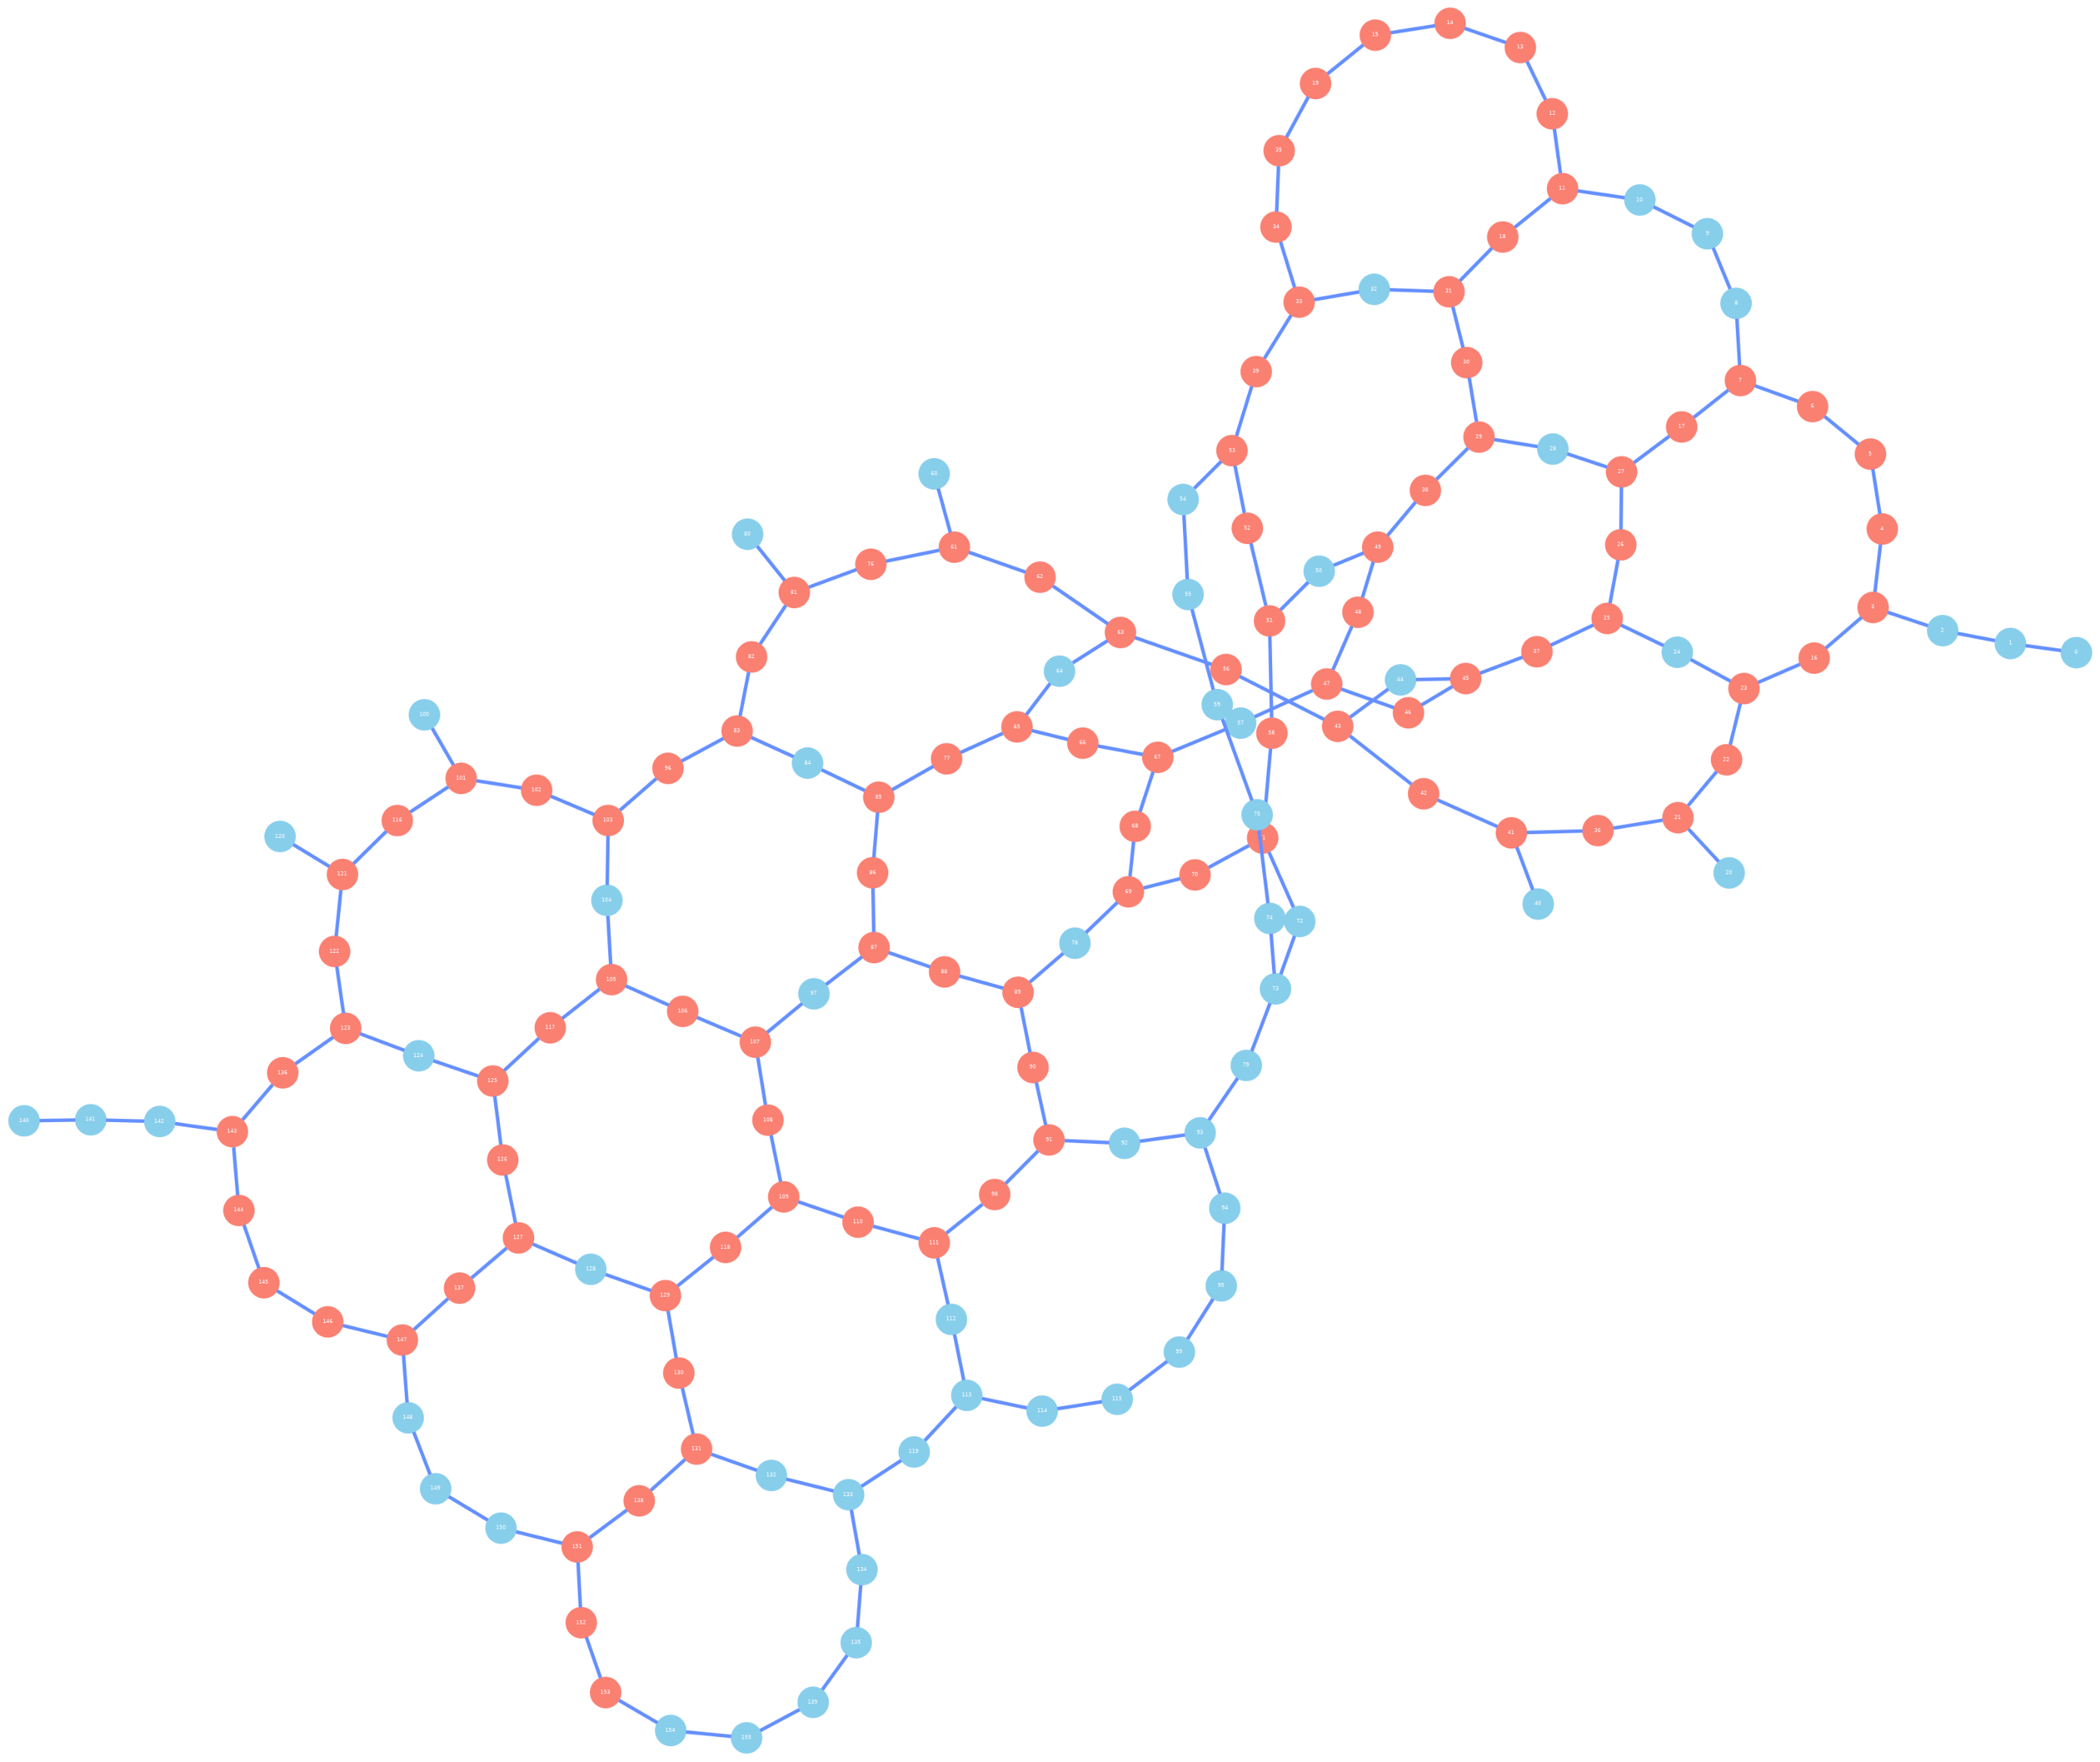

In [108]:
print(f'Chain for {machine}')
qcolors = ['salmon' if i in qchain else 'skyblue' for i in range(0, backend.configuration().n_qubits)]
plot_gate_map(backend, label_qubits=True, qubit_color=qcolors)

## Run layer fidelity on the selected chain

- `physical_qubits`: Physical qubits to use in this benchmarking
`two_qubit_layers`: List of list of qubit pairs (a list of qubit pairs corresponds with a two-qubit gate layer), qubit direction matters
- `cliff_lengths`: List of layer lengths (the number of depth points)
- `backend`: Backend to be benchmarked
- `nseeds`: How many random circuits should be sampled for each layer length
- `seed`: Seed for the random number generator
- `nshots`: Number of shots
- `couplig_map`: Device map with connections

- `two_qubit_gate`: Two-qubit gate name to use in layers (If not specified, one of 2q-gates supported in the backend is automatically set.)
- `one_qubit_basis_gates`: One-qubit gate names to use for random 1q-Clifford layers (If not specified, all 1q-gates supported in the backend are automatically set.)



In [35]:
# Define experiment parameters
nseeds = 6
nshots = 200
cliff_lengths = [1, 10, 20, 30, 40, 60, 80, 100, 150, 200, 400]
seed = 42

In [41]:
# Run LF
exp_data = run_lf_chain(
    chain=qchain,
    backend=backend,
    nseeds=nseeds,
    seed=seed,
    cliff_lengths=cliff_lengths,
    nshots=nshots,
    twoq_gate=twoq_gate,
    oneq_gates=oneq_gates,
    coupling_map=coupling_map)

Disjoint layer 1
[(108, 107), (106, 105), (117, 125), (126, 127), (137, 147), (146, 145), (144, 143), (136, 123), (122, 121), (116, 101), (102, 103), (96, 83), (82, 81), (76, 61), (62, 63), (56, 43), (42, 41), (36, 21), (22, 23), (16, 3), (4, 5), (6, 7), (17, 27), (26, 25), (37, 45), (46, 47), (48, 49), (38, 29), (30, 31), (18, 11), (12, 13), (14, 15), (19, 35), (34, 33), (39, 53), (52, 51), (58, 71), (70, 69), (68, 67), (66, 65), (77, 85), (86, 87), (88, 89), (90, 91), (98, 111), (110, 109), (118, 129), (130, 131), (138, 151), (152, 153)]
Disjoint layer 2
[(107, 106), (105, 117), (125, 126), (127, 137), (147, 146), (145, 144), (143, 136), (123, 122), (121, 116), (101, 102), (103, 96), (83, 82), (81, 76), (61, 62), (63, 56), (43, 42), (41, 36), (21, 22), (23, 16), (3, 4), (5, 6), (7, 17), (27, 26), (25, 37), (45, 46), (47, 48), (49, 38), (29, 30), (31, 18), (11, 12), (13, 14), (15, 19), (35, 34), (33, 39), (53, 52), (51, 58), (71, 70), (69, 68), (67, 66), (65, 77), (85, 86), (87, 88), 

In [40]:
def to_edges(
    path: List[int], coupling_map: CouplingMap, G: rx.PyDiGraph
) -> List[Tuple[int]]:
    """
    Return a list of edges from a path of qubits.
    Args:
    - path: List of nodes (qubits)
    - coupling_map: map containing connections
    - G: graph
    Returns:
    - List of edges
    """

    edges = []
    prev_node = None
    # Get all prossible edges from the nodes provided
    for node in path:
        if prev_node is not None:
            # Check the edge is in G and in the coupling map
            if G.has_edge(prev_node, node) and (prev_node, node) in coupling_map:
                edges.append((prev_node, node))
            elif G.has_edge(node, prev_node) and (node, prev_node) in coupling_map:
                edges.append((node, prev_node))
        prev_node = node
    return edges

def run_lf_chain(
    chain: List[int],
    backend: IBMBackend,
    nseeds: int,
    seed: int,
    cliff_lengths: List[int],
    nshots: int,
    twoq_gate: str,
    oneq_gates: List[str],
    coupling_map: CouplingMap,
) -> ExperimentData:
    
    """ General function to run LF on a list of chains using default or
    command lie arguments. Note: If one hopes to run LF on a single chain,
    the single chain should be passed as a list with one element.
    Args:
    - best_qubit_chains: List of chains to run
    - backend
    - nseeds
    - cliff_lengths
    - nshots
    - twoq_gate: type of two qubit gate 
    - oneq_gates: list one qubits gates
    Returns:
    - List of ExperimentData objects
    """

    # Get graph from coupling map
    G = coupling_map.graph

    # Decompose chain into trivial two disjoint layers (list of list of gates)
    all_pairs = to_edges(chain, coupling_map, G)
    layers = [all_pairs[0::2], all_pairs[1::2]] # will run a layer for each list

    # Check that each list is in the coupling map and is disjoint
    for layer in layers:
        for qpair in layer:
            if tuple(qpair) not in coupling_map:
                raise ValueError(f"Gate on {qpair} does not exist")

            for k in layer:
                if k == qpair:
                    continue

                if k[0] in qpair or k[1] in qpair:
                    print(f'Warning: sets are not disjoint for gate {k} and {qpair}')
    print('Disjoint layer 1')
    print(layers[0])
    print('Disjoint layer 2')
    print(layers[1])

    # Create LF instance
    lfexp = LayerFidelity(
        physical_qubits=chain,
        two_qubit_layers=layers,
        lengths=cliff_lengths,
        backend=backend,
        num_samples=nseeds,
        seed=seed,
        two_qubit_gate=twoq_gate,
        one_qubit_basis_gates=oneq_gates,
    )
    lfexp.set_experiment_options(max_circuits=2 * nseeds * len(cliff_lengths))
    
    # Generate all 2Q direct RB circuits
    circuits = lfexp.circuits()
    print(f"{len(circuits)} circuits are generated.")

    # Run LF experiment (generate circuits and submit the job)
    exp_data = lfexp.run(backend, shots=nshots)
    exp_data.auto_save = False
    print(f"Run experiment: ID={exp_data.experiment_id} with jobs {exp_data.job_ids}]")
    return exp_data


## Quick look at circuits (for visualization purposes)

This cell can be skipped. The function `run_lf_chain()` will run LF on the selected chain without the need to run this cell.

CPU times: user 17.5 s, sys: 199 ms, total: 17.7 s
Wall time: 17.8 s


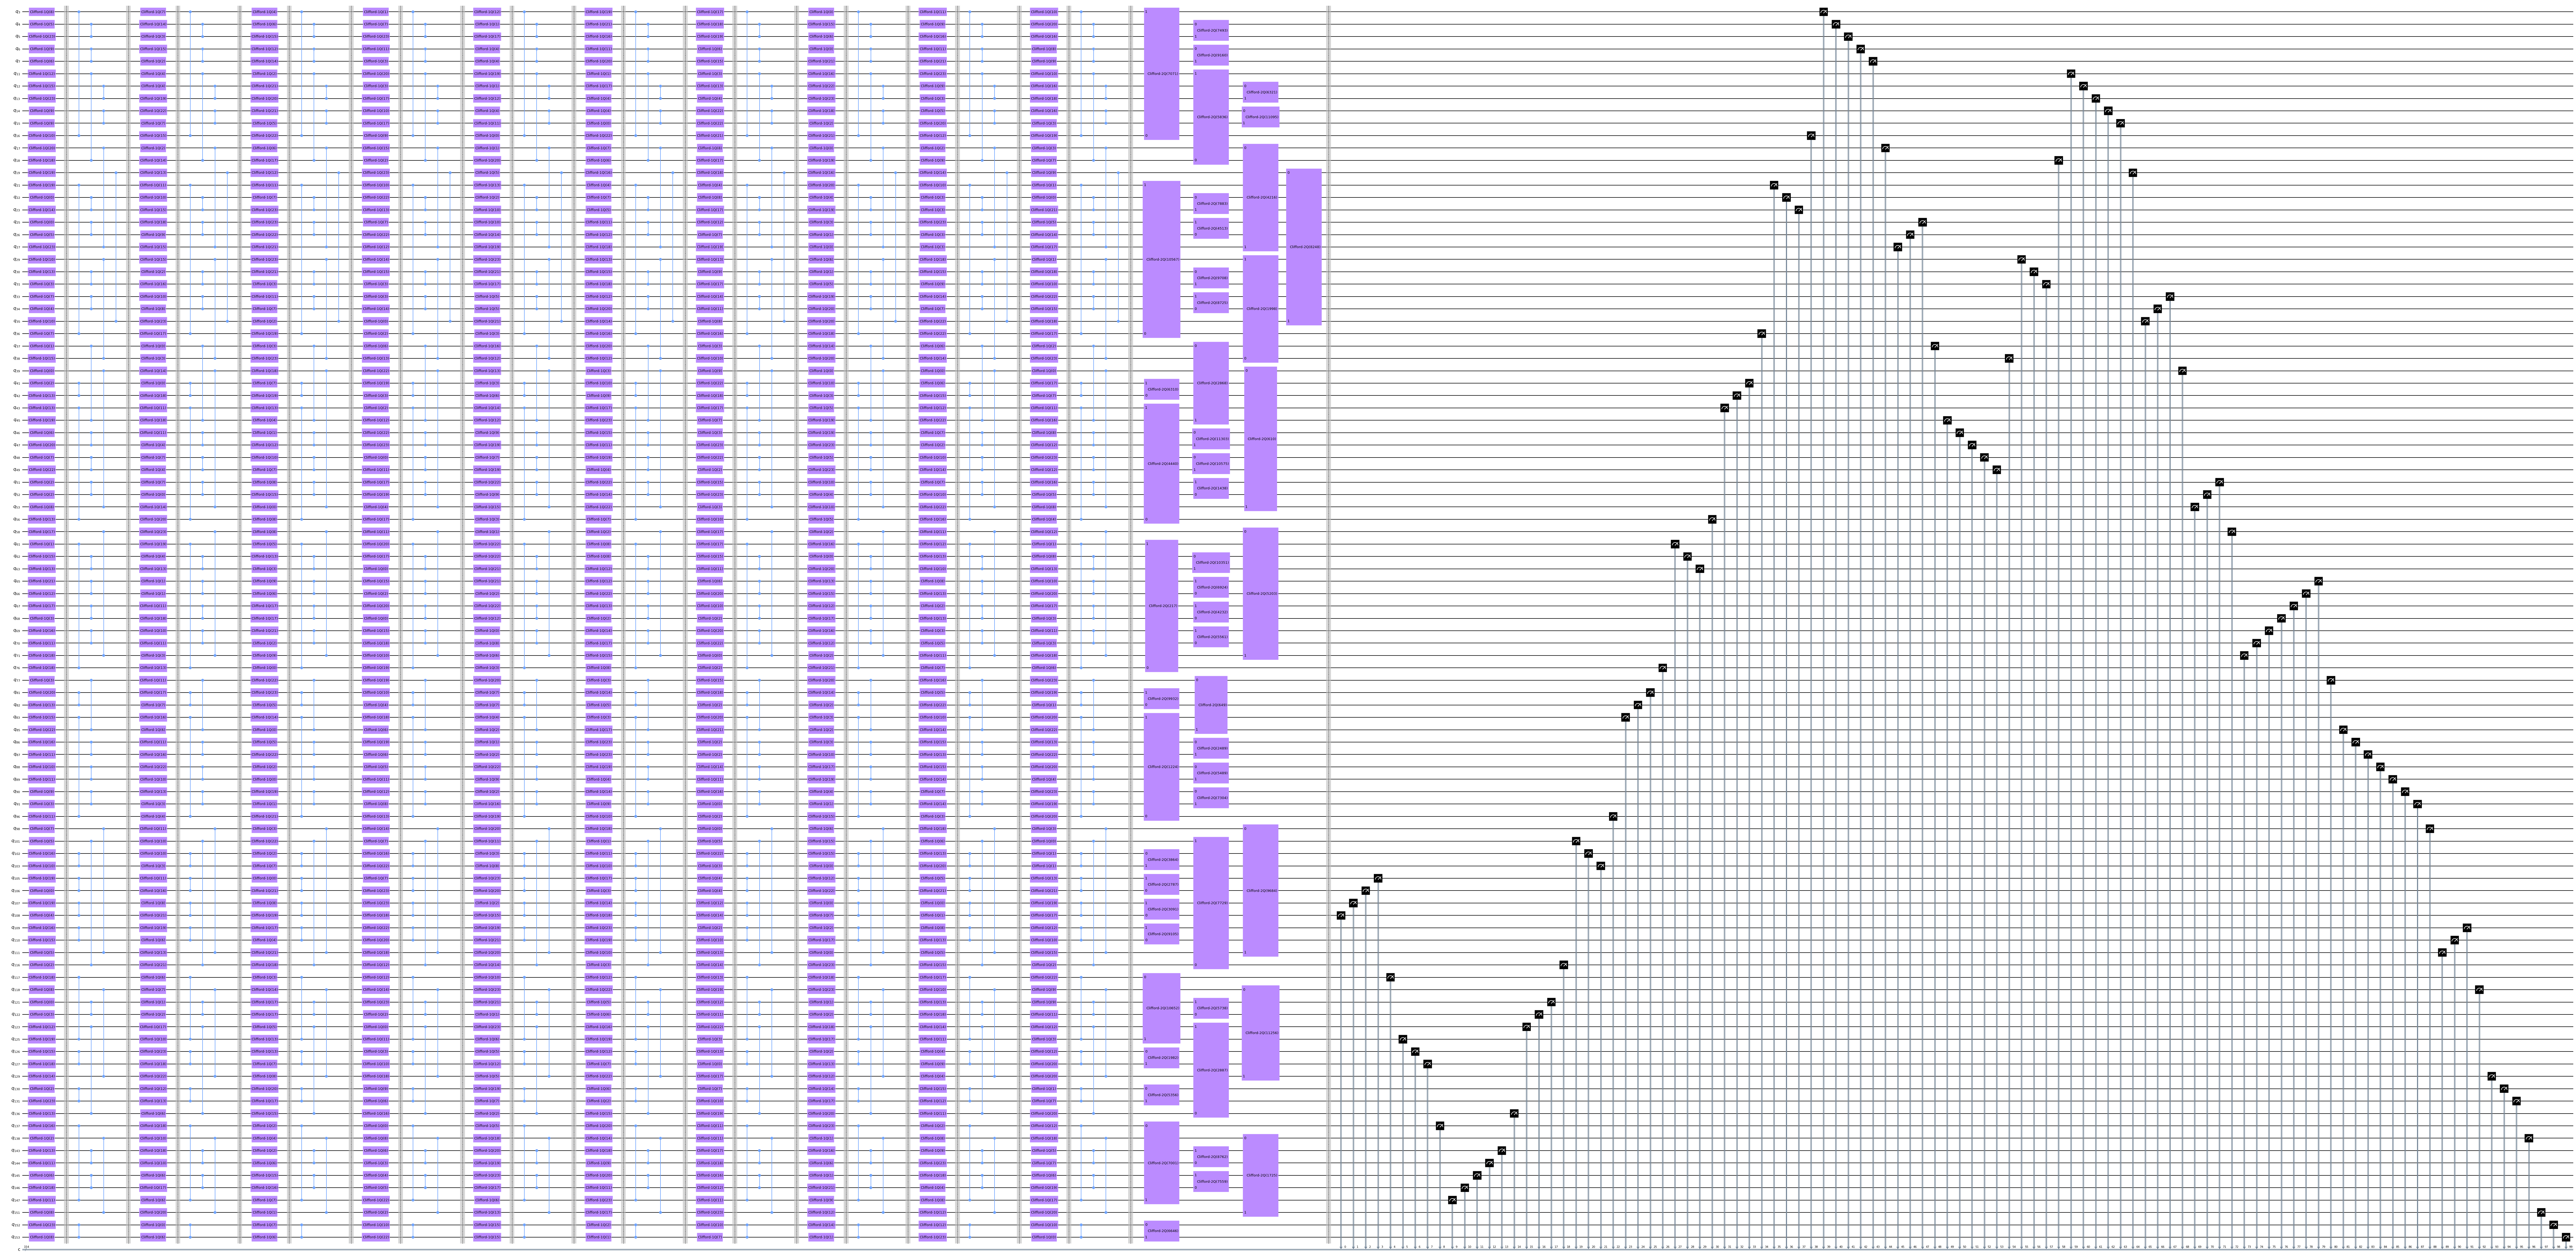

In [122]:
%%time
# Get graph from coupling map
G = coupling_map.graph

# Decompose chain into trivial two disjoint layers (list of list of gates)
all_pairs = to_edges(qchain, coupling_map, G)
layers = [all_pairs[0::2], all_pairs[1::2]] # will run a layer for each list

# Create Layer Fidelity Instance
lfexp = LayerFidelity(
        physical_qubits=qchain,
        two_qubit_layers=layers,
        lengths=cliff_lengths,
        backend=backend,
        num_samples=nseeds,
        seed=seed,
        two_qubit_gate=twoq_gate,
        one_qubit_basis_gates=oneq_gates,
    )
lfexp.set_experiment_options(max_circuits=2 * nseeds * len(cliff_lengths))
    
# look at one of the first three 2Q direct RB circuits quickly
circ_iter = lfexp.circuits_generator()
first_three_circuits = list(next(circ_iter) for _ in range(3))
first_three_circuits[1].draw(output="mpl", style="clifford", idle_wires=False, fold=-1)

## Running and retrieving experiment analysis

This will take some time depending on the queue

In [43]:
%%time
# Fit 2Q experiment data
exp_data.block_for_results()

CPU times: user 11.9 s, sys: 10.8 s, total: 22.7 s
Wall time: 12min 50s


ExperimentData(LayerFidelity, 87b60f1e-6664-4e71-9d51-00e4f6b0c4e0, job_ids=['ctf6xnpakxxg008n4ej0'], metadata=<4 items>, figure_names=['DirectRB_Q108_Q107.svg', 'DirectRB_Q106_Q105.svg', 'DirectRB_Q117_Q125.svg', 'DirectRB_Q126_Q127.svg', 'DirectRB_Q137_Q147.svg', 'DirectRB_Q146_Q145.svg', 'DirectRB_Q144_Q143.svg', 'DirectRB_Q136_Q123.svg', 'DirectRB_Q122_Q121.svg', 'DirectRB_Q116_Q101.svg', 'DirectRB_Q102_Q103.svg', 'DirectRB_Q96_Q83.svg', 'DirectRB_Q82_Q81.svg', 'DirectRB_Q76_Q61.svg', 'DirectRB_Q62_Q63.svg', 'DirectRB_Q56_Q43.svg', 'DirectRB_Q42_Q41.svg', 'DirectRB_Q36_Q21.svg', 'DirectRB_Q22_Q23.svg', 'DirectRB_Q16_Q3.svg', 'DirectRB_Q4_Q5.svg', 'DirectRB_Q6_Q7.svg', 'DirectRB_Q17_Q27.svg', 'DirectRB_Q26_Q25.svg', 'DirectRB_Q37_Q45.svg', 'DirectRB_Q46_Q47.svg', 'DirectRB_Q48_Q49.svg', 'DirectRB_Q38_Q29.svg', 'DirectRB_Q30_Q31.svg', 'DirectRB_Q18_Q11.svg', 'DirectRB_Q12_Q13.svg', 'DirectRB_Q14_Q15.svg', 'DirectRB_Q19_Q35.svg', 'DirectRB_Q34_Q33.svg', 'DirectRB_Q39_Q53.svg', 'Direct

In [117]:
# Retrieve raw and fitted RB data
rb_data_df = pd.DataFrame()
df = exp_data.analysis_results(dataframe=True)
if len(df) > 0:
    for exp_pair in exp_data.artifacts("curve_data"):
        curve_data_id = exp_pair.artifact_id
        # Retrieve qubits
        q1 = exp_data.artifacts(curve_data_id).device_components[0].index
        qubits = (q1,)
        if len(exp_data.artifacts(curve_data_id).device_components) > 1:
            q2 = exp_data.artifacts(curve_data_id).device_components[1].index
            qubits = (q1,q2)
        # Retrieve by ID
        scatter_table = exp_data.artifacts(curve_data_id).data
        data_df = scatter_table.dataframe
        data_df['qubits'] = [qubits] * len(data_df)
        rb_data_df = pd.concat([rb_data_df, data_df], ignore_index=True)
rb_data_df

,xval,yval,yerr,series_name,series_id,category,shots,analysis,qubits
0,1.0,0.91791,0.019314,rb_decay,0,raw,200,_ProcessFidelityAnalysis,"(108, 107)"
1,10.0,0.937811,0.016992,rb_decay,0,raw,200,_ProcessFidelityAnalysis,"(108, 107)"
2,20.0,0.89801,0.021293,rb_decay,0,raw,200,_ProcessFidelityAnalysis,"(108, 107)"
3,30.0,0.853234,0.024898,rb_decay,0,raw,200,_ProcessFidelityAnalysis,"(108, 107)"
4,40.0,0.828358,0.02653,rb_decay,0,raw,200,_ProcessFidelityAnalysis,"(108, 107)"
...,...,...,...,...,...,...,...,...,...
17872,383.878788,0.633894,0.012265,rb_decay,0,fitted,<NA>,_ProcessFidelityAnalysis,"(153,)"
17873,387.909091,0.631879,0.012491,rb_decay,0,fitted,<NA>,_ProcessFidelityAnalysis,"(153,)"
17874,391.939394,0.629887,0.012719,rb_decay,0,fitted,<NA>,_ProcessFidelityAnalysis,"(153,)"
17875,395.969697,0.627916,0.012949,rb_decay,0,fitted,<NA>,_ProcessFidelityAnalysis,"(153,)"


In [ ]:
# Save RB data locally
rb_data_df.to_csv('full_rb_data.csv', float_format='%.15f')

In [56]:
# Get LF result for a length of 100Q
df.loc[df['name']=='LF']

,name,experiment,components,value,quality,backend,run_time,qubits,reason,a,alpha,b,chisq
6666a692,LF,LayerFidelity,"[Q108, Q107, Q106, Q105, Q117, Q125, Q126, Q12...",0.5670+/-0.0025,bad,ibm_fez,None,None,None,None,None,None,None


In [57]:
# Get EPLG result for a length of 100Q
df.loc[df['name']=='EPLG']

,name,experiment,components,value,quality,backend,run_time,qubits,reason,a,alpha,b,chisq
402aea11,EPLG,LayerFidelity,"[Q108, Q107, Q106, Q105, Q117, Q125, Q126, Q12...",0.00572+/-0.00004,bad,ibm_fez,None,None,None,None,None,None,None


In [62]:
# Get process fidelities per two qubit pair
df.loc[df['name']=='ProcessFidelity']

,name,experiment,components,value,quality,backend,run_time,qubits,reason,a,alpha,b,chisq
d7d7fbb9,ProcessFidelity,LayerFidelity,"[Q108, Q107]",0.9979+/-0.0005,good,ibm_fez,None,"(108, 107)",None,0.895522,0.997754,0.039755,1.390178
7953c4cb,ProcessFidelity,LayerFidelity,"[Q106, Q105]",0.9968+/-0.0004,good,ibm_fez,None,"(106, 105)",None,0.77615,0.996613,0.185254,0.703453
61fea5db,ProcessFidelity,LayerFidelity,"[Q117, Q125]",0.9953+/-0.0004,good,ibm_fez,None,"(117, 125)",None,0.765051,0.994935,0.206881,1.330441
80222b7a,ProcessFidelity,LayerFidelity,"[Q126, Q127]",0.9893+/-0.0004,good,ibm_fez,None,"(126, 127)",None,0.730739,0.988593,0.232695,2.161318
4a0d25dd,ProcessFidelity,LayerFidelity,"[Q137, Q147]",0.9948+/-0.0004,good,ibm_fez,None,"(137, 147)",None,0.645712,0.994487,0.288441,1.271409
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d1b69f9,ProcessFidelity,LayerFidelity,"[Q129, Q130]",0.9940+/-0.0004,good,ibm_fez,None,"(129, 130)",None,0.637725,0.993563,0.246393,2.50078
7e9e237c,ProcessFidelity,LayerFidelity,"[Q131, Q138]",0.9946+/-0.0004,good,ibm_fez,None,"(131, 138)",None,0.688137,0.994261,0.256458,1.060585
9e71383e,ProcessFidelity,LayerFidelity,"[Q151, Q152]",0.99594+/-0.00032,good,ibm_fez,None,"(151, 152)",None,0.688563,0.995672,0.242157,0.91385
7917b432,ProcessFidelity,LayerFidelity,[Q108],0.9994+/-0.0005,bad,ibm_fez,None,"(108,)",biased_tail,0.962557,0.999186,0.0,2.364314


## Filter qubit pairs with bad process fidelity

In [110]:
# Select table with process fidelities
pfdf = df[(df.name == "ProcessFidelity")]

# Find bad quality analysis results
pfdf[pfdf.quality == "bad"]

,name,experiment,components,value,quality,backend,run_time,qubits,reason,a,alpha,b,chisq
947340ce,ProcessFidelity,LayerFidelity,"[Q146, Q145]",0.9965+/-0.0004,bad,ibm_fez,None,"(146, 145)",large_chisq,0.750363,0.996303,0.168517,7.315918
f2ab826d,ProcessFidelity,LayerFidelity,"[Q136, Q123]",0.99600+/-0.00022,bad,ibm_fez,None,"(136, 123)",large_chisq,0.754907,0.995733,0.193522,3.686312
04dca4b8,ProcessFidelity,LayerFidelity,"[Q116, Q101]",0.9923+/-0.0006,bad,ibm_fez,None,"(116, 101)",large_chisq,0.715627,0.991795,0.197838,3.443936
a73d9cdc,ProcessFidelity,LayerFidelity,"[Q96, Q83]",0.99650+/-0.00031,bad,ibm_fez,None,"(96, 83)",large_chisq,0.758353,0.996265,0.112199,4.340359
1c4daabe,ProcessFidelity,LayerFidelity,"[Q42, Q41]",0.9945+/-0.0006,bad,ibm_fez,None,"(42, 41)",large_chisq,0.461411,0.994184,0.322667,4.655299
968a3a22,ProcessFidelity,LayerFidelity,"[Q4, Q5]",0.99442+/-0.00029,bad,ibm_fez,None,"(4, 5)",large_chisq,0.716583,0.994044,0.205817,4.280329
8089f4d7,ProcessFidelity,LayerFidelity,"[Q30, Q31]",0.9704+/-0.0018,bad,ibm_fez,None,"(30, 31)",large_chisq,0.629642,0.968418,0.265055,4.020114
1e37028f,ProcessFidelity,LayerFidelity,"[Q12, Q13]",0.99536+/-0.00035,bad,ibm_fez,None,"(12, 13)",large_chisq,0.656082,0.995046,0.273843,3.355638
e6d4a4ae,ProcessFidelity,LayerFidelity,"[Q107, Q106]",0.99389+/-0.00027,bad,ibm_fez,None,"(107, 106)",large_chisq,0.732578,0.993485,0.251329,6.862128
318c3040,ProcessFidelity,LayerFidelity,"[Q105, Q117]",0.9826+/-0.0005,bad,ibm_fez,None,"(105, 117)",large_chisq,0.834431,0.981483,0.190313,55.911404


## Plotting RB results

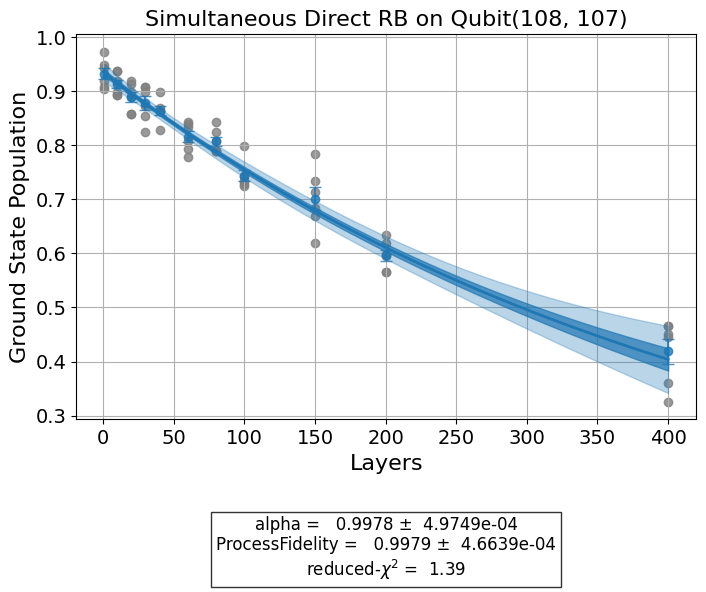

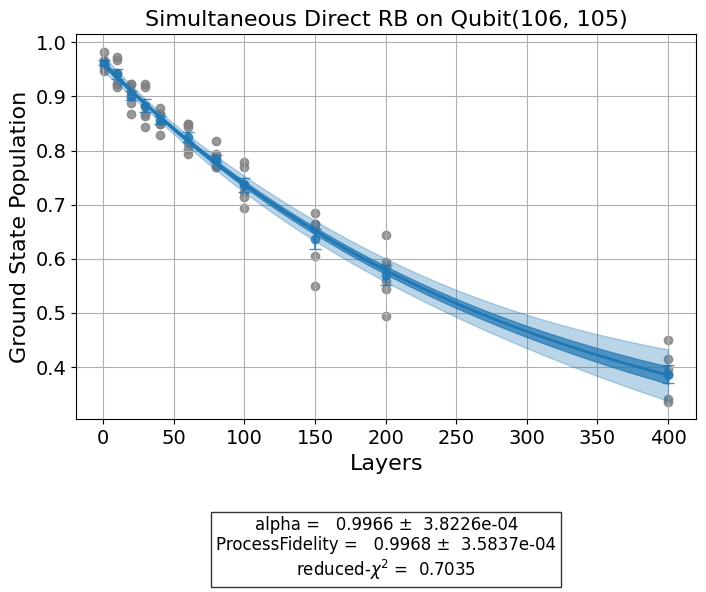

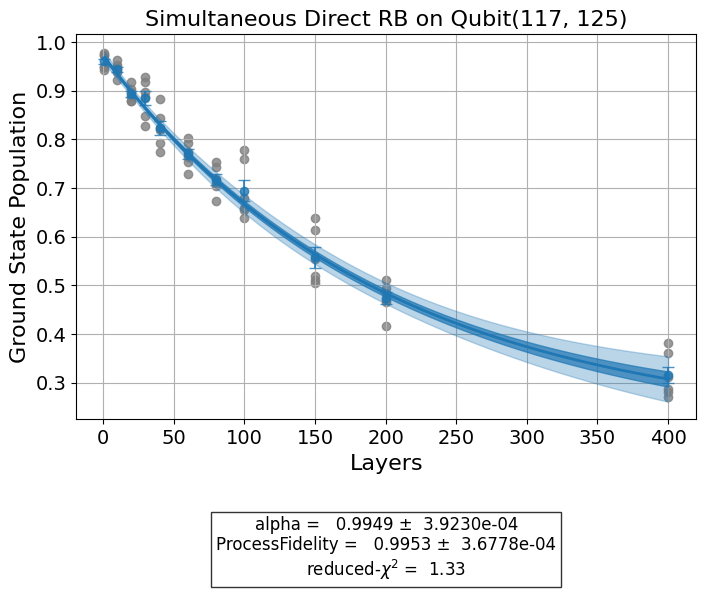

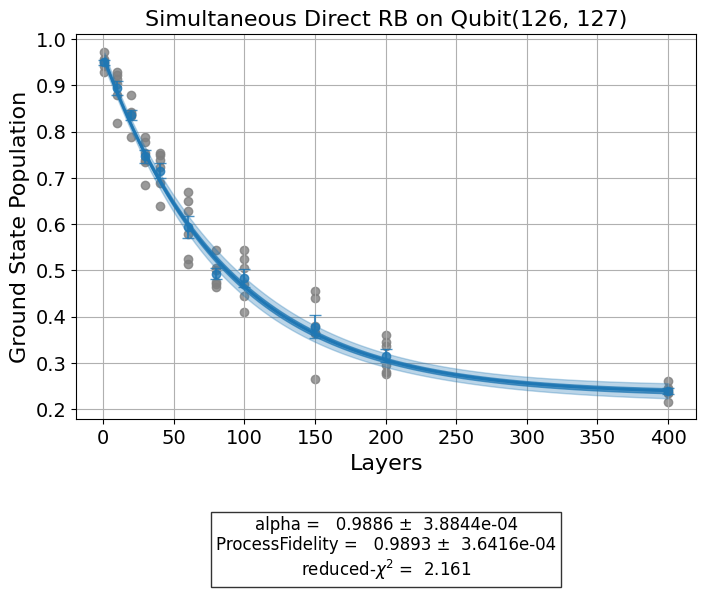

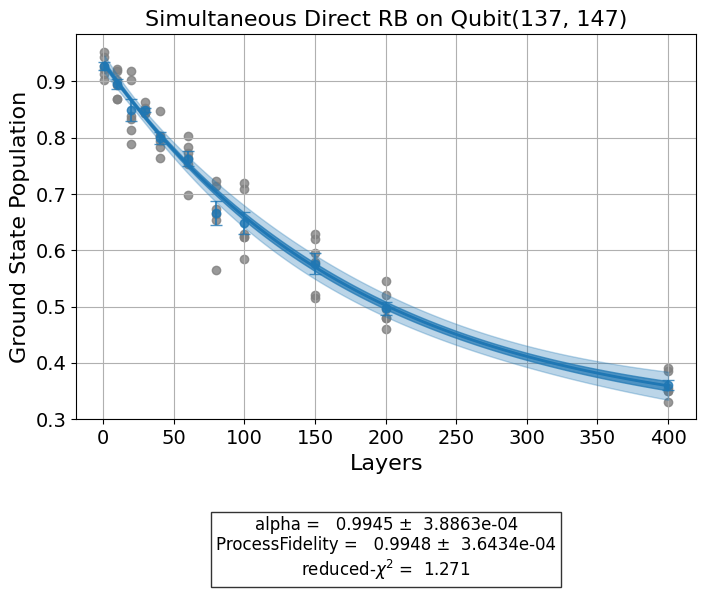

In [60]:
# Plot 1Q/2Q simultaneous direct RB curves
for i in range(5):
    display(exp_data.figure(i))

## Reconstruct LF and EPLG array per chain length

Construct LF and EPLG arrays ranging in length for the selected 100Q chain. This is different from obtaining the Layer Fidelity and EPLG value in the initial df, as those values only concern a length of 100 qubits.

In [94]:
# Get the coupling_map
G = coupling_map.graph

# Recover layers from experiment
all_pairs = to_edges(qchain, coupling_map, G)
layers = [all_pairs[0::2], all_pairs[1::2]]  # will run a layer for each list
full_layer = [None] * (len(layers[0]) + len(layers[1]))
full_layer[::2] = layers[0]
full_layer[1::2] = layers[1]
full_layer = [(qchain[0],)] + full_layer + [(qchain[-1],)]

# Compute LF by chain length assuming the first layer is full with 2q-gates
pfdf = df[df.name == "ProcessFidelity"]
pfdf = pfdf.fillna({"value": 0}) # Fill Process Fidelity nan values with zeros
results_per_chain = []
# Check if the dataframe is empty
if len(pfdf) > 0:
    pfs = [pfdf.loc[pfdf[pfdf.qubits == qubits].index[0], 'value'] for qubits in full_layer]
    pfs = list(map(lambda x: x.n if x != 0 else 0, pfs))
    pfs[0] = pfs[0] ** 2
    pfs[-1] = pfs[-1] ** 2

    # Approximate 1Q RB fidelities at both ends by the square root of 2Q RB fidelity at
    # both ends. For example, if we have [(0, 1), (1, 2), (2, 3), (3, 4)] 2Q RB fidelities
    # and if we want to compute a layer fidelity for [1, 2, 3], we approximate the 1Q
    # filedities for (1,) and (3,) by the square root of 2Q fidelities of (0, 1) and (3, 4).
    chain_lens = np.arange(4, len(pfs), 2)
    chain_fids = []
    for length in chain_lens:
        w = length + 1  # window size
        fid_w = max(
            np.sqrt(pfs[s]) * np.prod(pfs[s + 1 : s + w - 1]) * np.sqrt(pfs[s + w - 1])
            for s in range(len(pfs) - w + 1)
        )
        chain_fids.append(fid_w)

    # Get EPLG by chain length
    num_2q_gates = [length - 1 for length in chain_lens]
    chain_eplgs = [
        1 - (fid ** (1 / num_2q)) for num_2q, fid in zip(num_2q_gates, chain_fids)
    ]
    results_per_chain.append(
        {
            'qchain': list(qchain),
            'lf': np.asarray(chain_fids),
            'eplg': np.asarray(chain_eplgs),
            'length': np.asarray(chain_lens),
            'job_ids': exp_data.job_ids
        }
    )

# Save data
results_per_chain = pd.DataFrame.from_dict(results_per_chain)
results_per_chain.to_csv(f'{machine}_lf_eplg_data.csv', float_format='%.15f')

In [95]:
results_per_chain

,qchain,lf,eplg,length,job_ids
0,"[108, 107, 106, 105, 117, 125, 126, 127, 137, ...","[0.9862460645717719, 0.9792970043734253, 0.971...","[0.004605826209038488, 0.004175320451491049, 0...","[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, ...",[ctf6xnpakxxg008n4ej0]


In [102]:
# Lengths
results_per_chain['length'].values

array([array([  4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,  28,
               30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,  54,
               56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,  80,
               82,  84,  86,  88,  90,  92,  94,  96,  98, 100])              ],
      dtype=object)

In [101]:
# LFs per length
results_per_chain['lf'].values

array([array([0.98624606, 0.979297  , 0.97199262, 0.96441984, 0.95707797,
              0.94908091, 0.94005791, 0.92991956, 0.91938301, 0.91051402,
              0.90145788, 0.89182343, 0.88153558, 0.87135105, 0.86348525,
              0.85527601, 0.84666182, 0.84025513, 0.83275147, 0.82486123,
              0.7882218 , 0.77693208, 0.76888223, 0.76156679, 0.75615527,
              0.74575159, 0.73048566, 0.72194504, 0.71499257, 0.70696342,
              0.70001172, 0.68824659, 0.67974238, 0.67188092, 0.66335712,
              0.65670186, 0.64974005, 0.64224481, 0.63527113, 0.62827461,
              0.62273841, 0.61683745, 0.61049723, 0.60610604, 0.60095458,
              0.59015157, 0.57888471, 0.57103689, 0.56697923])           ],
      dtype=object)

In [98]:
# EPLGs per length
results_per_chain['eplg'].values

array([array([0.00460583, 0.00417532, 0.00404993, 0.0040173 , 0.00398028,
              0.00401202, 0.00411244, 0.00426483, 0.00441404, 0.00445415,
              0.00450036, 0.00456901, 0.00465911, 0.00473738, 0.0047236 ,
              0.0047261 , 0.00474454, 0.004693  , 0.00468183, 0.00468509,
              0.00551903, 0.00559324, 0.00557626, 0.0055433 , 0.00546557,
              0.00551986, 0.00569365, 0.00569959, 0.00567002, 0.00566873,
              0.00564525, 0.00573133, 0.00574524, 0.00574682, 0.00576419,
              0.00574406, 0.00573261, 0.00573396, 0.00572662, 0.00572157,
              0.00569012, 0.00566799, 0.00565614, 0.00561005, 0.00558037,
              0.00565466, 0.00573771, 0.00575965, 0.00571525])           ],
      dtype=object)

In [103]:
# jobs_id
results_per_chain['job_ids'].values

array([list(['ctf6xnpakxxg008n4ej0'])], dtype=object)

## Plot LF and EPLG per chain length

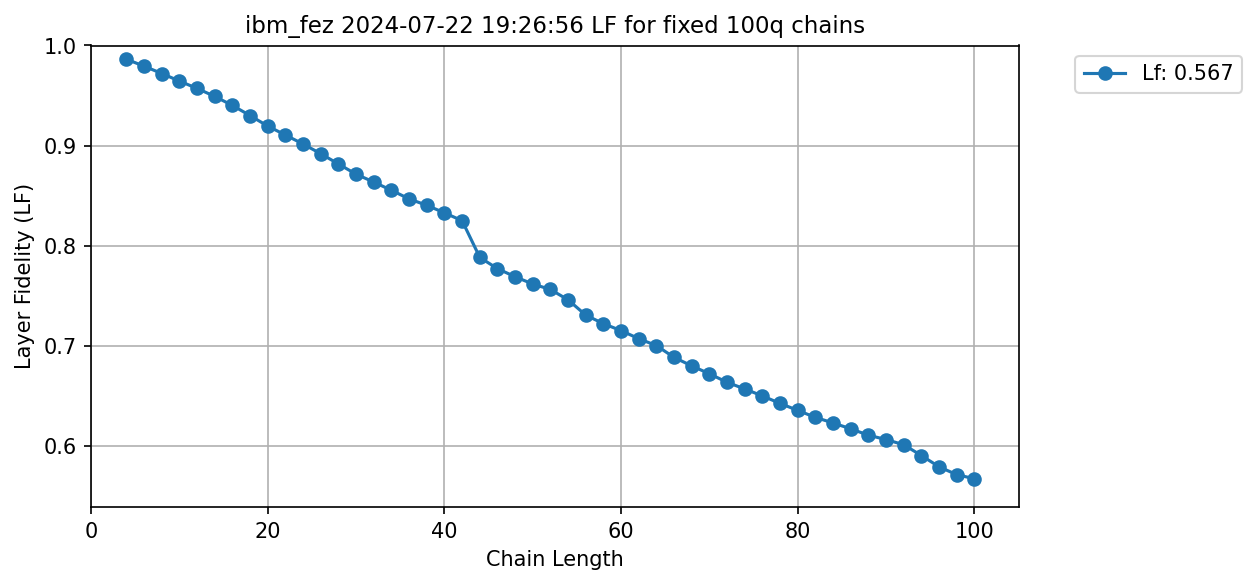

In [114]:
time = datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S")

# Plot LF by chain length
fig1, ax1 = plt.subplots(figsize=(8.5, 4))
title_lf = f"{machine} {time} LF for fixed {len(qchain)}q chains"
label_lf = f'Lf: {np.round(chain_fids[-1],3)}'
ax1.plot(chain_lens, chain_fids, marker="o", linestyle="-", label=label_lf) # lfs
ax1.set_title(title_lf, fontsize=11)
ax1.set_xlim(0, chain_lens[-1] * 1.05)
ax1.set_ylim(0.95 * min(chain_fids), 1)
ax1.set_ylabel("Layer Fidelity (LF)")
ax1.set_xlabel("Chain Length")
ax1.grid()
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax1.figure.set_dpi(150)
fig1.tight_layout()
fig1.savefig(f'{machine}_lf.png')


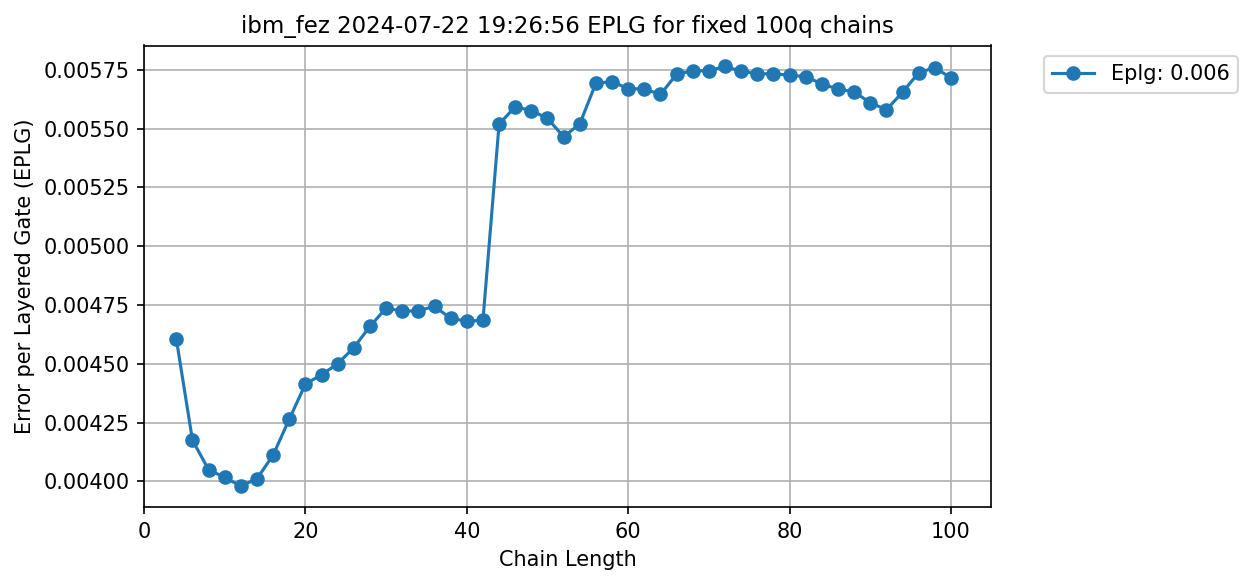

In [115]:
# Plot EPLG by chain length
fig2, ax2 = plt.subplots(figsize=(8.5, 4))
label_eplg = f'Eplg: {np.round(chain_eplgs[-1],3)}'
title_eplg = f"{machine} {time} EPLG for fixed {len(qchain)}q chains"
ax2.plot(chain_lens, chain_eplgs, marker="o", linestyle="-", label=label_eplg) # eplgs
ax2.set_title(title_eplg, fontsize=11)
ax2.set_xlim(0, chain_lens[-1] * 1.05)
ax2.set_ylabel("Error per Layered Gate (EPLG)")
ax2.set_xlabel("Chain Length")
ax2.grid()
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax2.figure.set_dpi(150)
fig2.tight_layout()
fig2.savefig(f'{machine}_eplg.png')

In [116]:
# Function that plots this automatically
def make_lf_eplg_plots(
    chain: List[int],
    exp_data: ExperimentData,
    machine: str,
    coupling_map: CouplingMap,
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    Extract experiment results for a list of chains and create a DataFrame
    with LF and EPLG values.
    Args:
    - best_qubit_chains: List of chains
    - lf_experiments_best: List of LF experiments
    - backend
    Returns:
    - DataFrame containing experiment results per chain
    """

    # Get the coupling_map
    G = coupling_map.graph

    # Recover layers from experiment
    all_pairs = to_edges(chain, coupling_map, G)
    layers = [all_pairs[0::2], all_pairs[1::2]]  # will run a layer for each list
    full_layer = [None] * (len(layers[0]) + len(layers[1]))
    full_layer[::2] = layers[0]
    full_layer[1::2] = layers[1]
    full_layer = [(chain[0],)] + full_layer + [(chain[-1],)]
    if len(full_layer) != len(chain) + 1:
        print(f'Length of full layer (= {len(full_layer)}) is not equal to length of the chain + 1 (= {len(chain) + 1})')
        print('Make sure the specified qubit chain is consistent with the device map')
        print(f'Full layer is {full_layer}')
        print(f'Chain is {chain}')
        exit()

    # Compute LF by chain length assuming the first layer is full with 2q-gates
    pfdf = df[df.name == "ProcessFidelity"]
    pfdf = pfdf.fillna({"value": 0}) # Fill Process Fidelity nan values with zeros
    results_per_chain = []
    # Check if the dataframe is empty
    if len(pfdf) > 0:
        pfs = [pfdf.loc[pfdf[pfdf.qubits == qubits].index[0], 'value'] for qubits in full_layer]
        pfs = list(map(lambda x: x.n if x != 0 else 0, pfs))
        pfs[0] = pfs[0] ** 2
        pfs[-1] = pfs[-1] ** 2

        # Approximate 1Q RB fidelities at both ends by the square root of 2Q RB fidelity at
        # both ends. For example, if we have [(0, 1), (1, 2), (2, 3), (3, 4)] 2Q RB fidelities
        # and if we want to compute a layer fidelity for [1, 2, 3], we approximate the 1Q
        # filedities for (1,) and (3,) by the square root of 2Q fidelities of (0, 1) and (3, 4).
        chain_lens = np.arange(4, len(pfs), 2)
        chain_fids = []
        for length in chain_lens:
            w = length + 1  # window size
            fid_w = max(
                np.sqrt(pfs[s]) * np.prod(pfs[s + 1 : s + w - 1]) * np.sqrt(pfs[s + w - 1])
                for s in range(len(pfs) - w + 1)
            )
            chain_fids.append(fid_w)

        # Get EPLG by chain length
        num_2q_gates = [length - 1 for length in chain_lens]
        chain_eplgs = [
            1 - (fid ** (1 / num_2q)) for num_2q, fid in zip(num_2q_gates, chain_fids)
        ]
        results_per_chain.append(
            {
                'qchain': list(chain),
                'lf': np.asarray(chain_fids),
                'eplg': np.asarray(chain_eplgs),
                'length': np.asarray(chain_lens),
                'job_ids': exp_data.job_ids
            }
        )
    
    # Make plots
    time = datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S")
    fig1, ax1 = plt.subplots(figsize=(8.5, 4))
    fig2, ax2 = plt.subplots(figsize=(8.5, 4))
    
    # Plot LF by chain length
    title_lf = f"{machine} {time} LF for fixed {len(chain)}q chains"
    label_lf = f'Lf: {np.round(chain_fids[-1],3)}'
    ax1.plot(chain_lens, chain_fids, marker="o", linestyle="-", label=label_lf) # lfs
    ax1.set_title(title_lf, fontsize=11)
    ax1.set_xlim(0, chain_lens[-1] * 1.05)
    ax1.set_ylim(0.95 * min(chain_fids), 1)
    ax1.set_ylabel("Layer Fidelity (LF)")
    ax1.set_xlabel("Chain Length")
    ax1.grid()
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    ax1.figure.set_dpi(150)
    fig1.tight_layout()
    fig1.savefig(f'{machine}_lf.png')
    
    # Plot EPLG by chain length
    label_eplg = f'Eplg: {np.round(chain_eplgs[-1],3)}'
    title_eplg = f"{machine} {time} EPLG for fixed {len(chain)}q chains"
    ax2.plot(chain_lens, chain_eplgs, marker="o", linestyle="-", label=label_eplg) # eplgs
    ax2.set_title(title_eplg, fontsize=11)
    ax2.set_xlim(0, chain_lens[-1] * 1.05)
    ax2.set_ylabel("Error per Layered Gate (EPLG)")
    ax2.set_xlabel("Chain Length")
    ax2.grid()
    ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    ax2.figure.set_dpi(150)
    fig2.tight_layout()
    fig2.savefig(f'{machine}_eplg.png')
    
# Usage
make_lf_eplg_plots(
    chain=qchain,
    exp_data=exp_data,
    machine=machine,
    coupling_map=coupling_map,
    df=df
)